In [2]:
%load_ext autoreload
%autoreload 2
import eval_models
import pandas as pd
import numpy as np
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['font.size'] = 25

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
X_dig_train,X_dig_test,y_dig_train,y_dig_test=eval_models.get_train_test("digits")

## No standarization at all

In [3]:
RF = RandomForestClassifier(n_jobs=-1, max_depth=6)
feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
feat_select.fit(X_dig_train.values,y_dig_train)
X_dig_train_boruta=X_dig_train.iloc[:,feat_select.support_]
X_dig_test_boruta=X_dig_test.iloc[:,feat_select.support_]

KeyboardInterrupt: 

In [ ]:
noscaling_res=eval_models.get_models_ba(X_dig_train_boruta,
                              X_dig_test_boruta,
                              y_dig_train,
                              y_dig_test
                             )

In [ ]:
X_train_no_corr=eval_models.delete_corr(X_dig_train_boruta)#,verbose=True)

In [ ]:
noscaling_res_cor=eval_models.get_models_ba(X_train_no_corr,
                              X_dig_test_boruta,
                              y_dig_train,
                              y_dig_test
                             )

## Standarization after Boruta

In [ ]:
X_dig_train_boruta_sc,X_dig_test_boruta_sc=eval_models.standarize(X_dig_train_boruta,X_dig_test_boruta)

In [ ]:
X_train_no_corr2=eval_models.delete_corr(X_dig_train_boruta_sc)

In [ ]:
noscaling_res_cor=eval_models.get_models_ba(X_train_no_corr2,
                              X_dig_test_boruta_sc,
                              y_dig_train,
                              y_dig_test
                             )

## Standarization before Boruta

In [ ]:
X_dig_train_sc,X_dig_test_sc=eval_models.standarize(X_dig_train,X_dig_test)

In [ ]:
### (suggested max_depth between 3 and 7) podobno
RF = RandomForestClassifier(n_jobs=-1, max_depth=7)
feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
feat_select.fit(X_dig_train_sc.values,y_dig_train)
X_dig_train_sc_boruta=X_dig_train_sc.iloc[:,feat_select.support_]
X_dig_test_sc_boruta=X_dig_test_sc.iloc[:,feat_select.support_]

In [ ]:
scaled_res=eval_models.get_models_ba(X_dig_train_sc_boruta,
                              X_dig_test_sc_boruta,
                              y_dig_train,
                              y_dig_test
                             )

In [ ]:
X_dig_train_sc_no_corr=eval_models.delete_corr(X_dig_train_sc_boruta)#,verbose=True)

In [ ]:
scaled_res_cor=eval_models.get_models_ba(X_dig_train_sc_no_corr,
                              X_dig_test_sc_boruta,
                              y_dig_train,
                              y_dig_test
                             )

## Cross validation (with standarization before Boruta)

In [ ]:
kf = KFold(n_splits=5,shuffle=True)
models_res=[]
for train_idx, val_idx in tqdm(kf.split(X_dig_train)):
    X_train=X_dig_train.iloc[train_idx,:]
    X_val=X_dig_train.iloc[val_idx,:]
    y_train=y_dig_train[train_idx]
    y_val=y_dig_train[val_idx]
    
    X_train_sc,X_val_sc=eval_models.standarize(X_train,X_val)
    
    RF = RandomForestClassifier(n_jobs=-1, max_depth=6)
    feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
    feat_select.fit(X_train.values,y_train)
    
    X_train_sc_boruta=X_train_sc.iloc[:,feat_select.support_]
    X_val_sc_boruta=X_val_sc.iloc[:,feat_select.support_]
    
    with open('../data/boruta/digits-features.csv', 'a') as f:
        np.savetxt(f, np.where(feat_select.support_), delimiter=",", fmt='%i')
    f.close()
    
    X_train_sc_boruta_no_corr=eval_models.delete_corr(X_train_sc_boruta)

    no_of_features=X_train_sc_boruta_no_corr.shape[1]
    tmp=eval_models.get_models_ba(X_train_sc_boruta_no_corr,X_val_sc_boruta,y_train,y_val)
    models_res.append(tmp)

In [ ]:
models_res.groupby(columns='Classifier').mean()

### Now, having run CV we will select only those variables which have been selected every time
YOU SHOULDN'T run the CV, it has been run already, if you wish to you should first clear file 'digits-features.csv'

In [4]:
boruta_all_results=pd.read_csv('../data/boruta/digits-features.csv',header=None,sep="\n")
boruta_all_results=boruta_all_results.iloc[:,0].str.split(',', expand=True)
x_times=boruta_all_results.shape[0]
boruta_all_array=np.array(list(filter(None, np.array(boruta_all_results).flatten()))).astype(np.int64)
unique, counts=np.unique(np.array(boruta_all_array).flatten(),return_counts=True)
columns_boruta= unique[counts>=x_times]
X_dig_train_boruta_multiple=X_dig_train.iloc[:,columns_boruta]
X_dig_train_boruta_multiple.head()

,2,12,14,16,25,34,38,48,53,66,...,4963,4966,4967,4970,4976,4977,4979,4980,4981,4991
2868,0,0,991,0,0,0,987,0,332,980,...,0,0,0,0,0,972,987,0,770,0
4630,0,645,991,0,983,0,0,0,0,983,...,991,991,0,0,0,0,662,0,0,0
1870,0,0,987,0,983,801,987,976,976,980,...,0,0,0,0,980,0,0,0,0,0
353,0,877,991,0,0,0,529,0,0,987,...,991,968,0,0,0,991,0,0,937,0
3582,0,0,0,0,831,0,0,0,0,570,...,991,991,0,0,0,874,0,0,0,0


In [6]:
eval_models.get_models_ba(X_dig_train_boruta_multiple,
                              X_dig_test,
                              y_dig_train,
                              y_dig_test,
                          n_estimators=250
                             )

LogisticRegression 0.972
RandomForestClassifier 0.9787
AdaBoostClassifier 0.9747
LGBMClassifier 0.9813
XGBClassifier 0.9807
954  features in the dataset


,Classifier,BA score
0,LogisticRegression,0.972000
1,RandomForestClassifier,0.978667
2,AdaBoostClassifier,0.974667
3,LGBMClassifier,0.981333
4,XGBClassifier,0.980667


I was impossible to run VIF on digits dataset :(

In [5]:
X_dig_train_scaled,X_dig_test_scaled=eval_models.standarize(X_dig_train,X_dig_test)
X_dig_train_scaled_boruta_multiple=X_dig_train_scaled.iloc[:,columns_boruta]

In [6]:
res_boruta_no_corr=eval_models.get_models_ba(X_dig_train_scaled_boruta_multiple,
                              X_dig_test_scaled,
                              y_dig_train,
                              y_dig_test,
                          n_estimators=250
                             )
res_boruta_no_corr['Corr']="No (954 features)"

LogisticRegression 0.9753
RandomForestClassifier 0.976
AdaBoostClassifier 0.9747
LGBMClassifier 0.9787
XGBClassifier 0.9807
954  features in the dataset


In [7]:
X_dig_train_scaled_boruta_multiple_corr=eval_models.delete_corr(X_dig_train_scaled_boruta_multiple,thresh=0.9)

In [8]:
res_boruta_yes_corr=eval_models.get_models_ba(X_dig_train_scaled_boruta_multiple_corr,
                              X_dig_test_scaled,
                              y_dig_train,
                              y_dig_test,
                          n_estimators=250)
res_boruta_yes_corr['Corr']="Yes (869 features)"

LogisticRegression 0.9727
RandomForestClassifier 0.9767
AdaBoostClassifier 0.9727
LGBMClassifier 0.9807
XGBClassifier 0.9787
869  features in the dataset


In [9]:
res_boruta_all=pd.concat([res_boruta_no_corr,res_boruta_yes_corr])
res_boruta_all.sort_values(by='BA score')

,Classifier,BA score,Corr
0,LogisticRegression,0.972667,Yes (869 features)
2,AdaBoostClassifier,0.972667,Yes (869 features)
2,AdaBoostClassifier,0.974667,No (954 features)
0,LogisticRegression,0.975333,No (954 features)
1,RandomForestClassifier,0.976000,No (954 features)
1,RandomForestClassifier,0.976667,Yes (869 features)
3,LGBMClassifier,0.978667,No (954 features)
4,XGBClassifier,0.978667,Yes (869 features)
3,LGBMClassifier,0.980667,Yes (869 features)
4,XGBClassifier,0.980667,No (954 features)


In [10]:
res_boruta_all.replace(to_replace=['LogisticRegression','RandomForestClassifier','AdaBoostClassifier','LGBMClassifier','XGBClassifier'],value=['Logistic Regression','Random Forest','AdaBoost','LightGBM','XGBoost'],inplace=True)

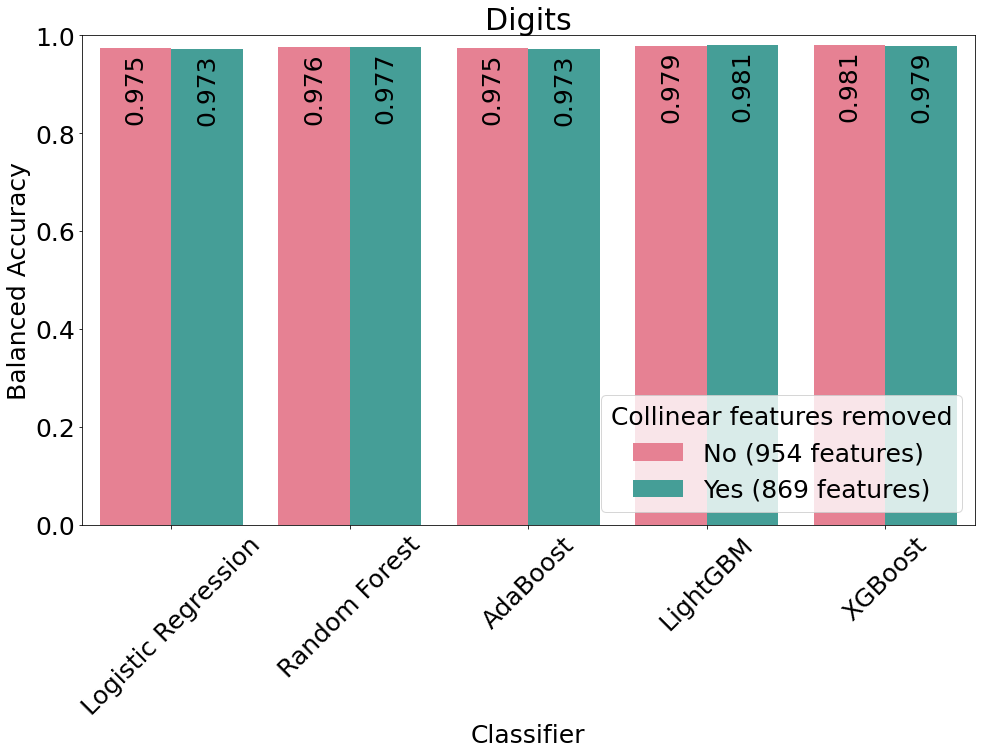

In [12]:
bars = sns.barplot(x='Classifier', y='BA score', hue='Corr', data=res_boruta_all,palette=sns.color_palette("husl", 2))
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()-0.1), ha='center', va='center', xytext=(0, 8), rotation=90,
                   textcoords='offset points')
plt.ylim(0, 1)
plt.legend(loc=4, title='Collinear features removed')
plt.xlabel('Classifier')
plt.ylabel('Balanced Accuracy')
plt.title('Digits')#\nClassifiers performance after Boruta feature selection')
plt.xticks(rotation=45)
plt.show()